In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing, svm, metrics
from sklearn.model_selection import LeaveOneGroupOut, KFold, GridSearchCV, GroupKFold, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.externals import joblib
from sklearn.datasets import make_regression
from scipy.stats import randint as sp_randint
from matplotlib import pyplot as plt
from collections import defaultdict

/Users/Zach/miniconda3/envs/ml_22.2/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
%matplotlib inline
import biom
import calour as ca
from scipy import stats
import scipy
import pickle
import time
import math
import inspect
import operator
pd.set_option('display.max_rows', 10000)

/Users/Zach/miniconda3/envs/ml_22.2/lib/python3.7/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


# Importing data, no TSS normalization performed here since table is already normalized

In [3]:
allMetab = ca.read_amplicon('PMI_MS1_FeatureTable_Normalized.biom','pmi3_metab_meta.txt', min_reads=1, normalize = None)

## Remove controls and samples that grouped with controls on PCoA

In [4]:
allMetab = allMetab.filter_samples('control', 'n')
allMetab = allMetab.filter_samples('pcoa_removals', 'n')
allMetab.sample_metadata.description.value_counts()

skin.hip    746
soil.hip    744
Name: description, dtype: int64

# Split by sampling location (soil v. skin)

## Skin sample filtering

In [5]:
Metab_skin = allMetab.filter_samples('sample_type', 'skin')
Metab_skin.sample_metadata.sample_type.value_counts()

skin    746
Name: sample_type, dtype: int64

In [6]:
print("Number of samples: ",len(Metab_skin.sample_metadata.metab_barcode.value_counts()))

Number of samples:  746


In [7]:
print("Number of bodies: ",len(Metab_skin.sample_metadata.subjectID.value_counts()))

Number of bodies:  36


In [8]:
print("Number of facilities: ",len(Metab_skin.sample_metadata.facility.value_counts()))

Number of facilities:  3


# Skin Facility Model using ADD 0C as Response and Adding Metadata as Features

In [9]:
Metab_skin_meta = Metab_skin.add_sample_metadata_as_features(['avg_percent_humidity','total_precipitation_cm'])
print("Number of features: ",len(Metab_skin_meta.feature_metadata))

Number of features:  4402


In [10]:
# designate data
X = Metab_skin_meta.data
y = Metab_skin_meta.sample_metadata['add_0c']
y = (y.astype(float))

# group by facility in outer loop
outer_groups = Metab_skin_meta.sample_metadata['facility']

# group by body in inner loop
inner_groups = Metab_skin_meta.sample_metadata['subjectID']

In [55]:
# outer_cv creates 3 folds by leave-one-facility-out for estimating generalization error
outer_cv = LeaveOneGroupOut().split(X, y, groups=outer_groups)

# prints the number of folds in the outer loop
print("Number of outer folds to perform: ", LeaveOneGroupOut().get_n_splits(X, y, groups=outer_groups))

# hyperparameter grid to test
#param_grid = {"max_depth": [None, 4],
#              "max_features": ['auto', 0.2],
#              "bootstrap": [True, False]}

param_grid = {"max_depth": [4],
              "max_features": [0.1],
              "bootstrap": [False]}

# creates loop iteration counter and empty lists for storage
count=1
model_parameters = []
nested_cv_scores = []

# loops through the sets of training and test ids in the outer loop
# the number of loops will match the number of folds as each fold is used
for train_ids, test_ids in outer_cv:
    # inner_cv creates 24 folds by leave-one-body-out for hyperparamter tuning
    # uses only the train ids present in the current outer loop fold which is one less facility since the outer loop
    # folds are using leave-one-facility-out
    inner_cv = LeaveOneGroupOut().split(X[train_ids, :], y.iloc[train_ids], groups=inner_groups[train_ids])
    # setting rf parameters
    rf = RandomForestRegressor(n_estimators=1, random_state=999, criterion='mae')
    # grid search cv using rf and the hyperparameter grid on the inner_cv training set
    rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=inner_cv, n_jobs=1, scoring='neg_mean_absolute_error')
    # fit the grid search model on the inner_cv training set, which will tell us the best
    # parameters chosen by that inner cv
    rf_grid.fit(X[train_ids, :], y.iloc[train_ids])
    # converts best params dict to string to save it
    res = ",".join(("{}={}".format(*i) for i in rf_grid.best_params_.items()))
    # attaches each loops best params
    model_parameters.append(res)
    # prints outer fold number the loop is currently on
    print("Outer fold:",count)
    # prints number of inner folds in the outer loop (should be the same each time at 24)
    print("Number of inner folds:",LeaveOneGroupOut().get_n_splits(X[train_ids, :], y.iloc[train_ids], groups=inner_groups[train_ids]))
    # prints best param and CV score from this inner loop set 
    print("Best params:",rf_grid.best_params_)
    print("Best CV score (MAE):",-rf_grid.best_score_)
    # uses the best model created from the inner loop to predict the outer loop body left out
    yhat = rf_grid.predict(X[test_ids,:])
    MAE = mean_absolute_error(y.iloc[test_ids], yhat)
    print("Prediction score (MAE):",MAE)
    nested_cv_scores.append(MAE)
    print("*****")
    count+=1
# prints the mean of the nested cv score (generalization error) of the models
print("\nNested CV score (generalization error): " + str(np.mean(nested_cv_scores)))

Number of outer folds to perform:  3
Outer fold: 1
Number of inner folds: 24
Best params: {'bootstrap': False, 'max_depth': 4, 'max_features': 0.1}
Best CV score (MAE): 80.7410221153679
Prediction score (MAE): 76.55908377972581
*****
Outer fold: 2
Number of inner folds: 24
Best params: {'bootstrap': False, 'max_depth': 4, 'max_features': 0.1}
Best CV score (MAE): 72.67046840977888
Prediction score (MAE): 90.61952253389558
*****
Outer fold: 3
Number of inner folds: 24
Best params: {'bootstrap': False, 'max_depth': 4, 'max_features': 0.1}
Best CV score (MAE): 83.28269028584347
Prediction score (MAE): 81.82394020381525
*****

Nested CV score (generalization error): 83.00084883914555


In [12]:
# define function to merge 2 lists as paired tuples    
def merge(list1, list2): 
    merged_list = tuple(zip(list1, list2))  
    return merged_list 

# merge parameters to nested scores as tuples
merged_list = merge(model_parameters, nested_cv_scores)

# puts the paired tuple list into a dictionary
params_and_scores = defaultdict(list)
for k, v in merged_list:
    params_and_scores[k].append(v)

In [13]:
# prints dict of params and scores, should see each set of parameters chosen and their scores
params_and_scores

defaultdict(list,
            {'bootstrap=False,max_depth=4,max_features=0.1': [76.55908377972581,
              90.61952253389558,
              81.82394020381525]})

In [14]:
# create a dict to assign the mean score to each param set
avgDict = {}
for k,v in params_and_scores.items():
    avgDict[k] = sum(v)/ float(len(v))
print(avgDict)

{'bootstrap=False,max_depth=4,max_features=0.1': 83.00084883914555}


In [15]:
# prints the param set with the best mean error
print("Best params:",min(avgDict, key=avgDict.get))
print("Best mean score:",min(avgDict.values()))

Best params: bootstrap=False,max_depth=4,max_features=0.1
Best mean score: 83.00084883914555


In [44]:
# input the best parameter set
best_model_params = {"max_depth": [4],
              "max_features": [0.1],
              "bootstrap": [False]}

final_regressor = RandomForestRegressor(n_estimators=1, random_state=999, criterion='mae', max_depth=4, max_features=0.1, bootstrap=False)


# now we refit this best model on the whole dataset so that we can start
# making predictions on other data, and now we have a reliable estimate of
# this model's generalization error and we are confident this is the best model
# among the ones we have tried
#final_regressor = GridSearchCV(rf, best_model_params, cv=LeaveOneGroupOut().split(X, y, groups=outer_groups), scoring='neg_mean_absolute_error', n_jobs=-1)
final_regressor.fit(X, y)
#print("Best CV score:",-final_regressor.best_score_)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mae',
                      max_depth=None, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1, n_jobs=None, oob_score=False,
                      random_state=999, verbose=0, warm_start=False)

In [45]:
joblib.dump(final_regressor, 'models/PMI3_Metab_skin_meta_facility.pkl')

['models/PMI3_Metab_skin_meta_facility.pkl']

In [46]:
model_Metab_skin_meta = joblib.load('models/PMI3_Metab_skin_meta_facility.pkl')

In [47]:
model_Metab_skin_meta

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mae',
                      max_depth=None, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1, n_jobs=None, oob_score=False,
                      random_state=999, verbose=0, warm_start=False)

### Determine important features

In [48]:
importances = model_Metab_skin_meta.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_Metab_skin_meta.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feature_metadata = Metab_skin_meta.feature_metadata
np.savetxt("feature_metadata/facility_skin_feature_metadata_meta.csv", feature_metadata, delimiter=",", fmt='%s')


#print the important ids in order
general_importances = []
count = 0
print("Feature:\t\t\t\tImportance:")
for i in indices:
    general_importances += (Metab_skin_meta.feature_metadata.index.values[i], importances[indices[count]])
    if count < 25:
        print(str(count+1)+". "+str(Metab_skin_meta.feature_metadata.index.values[i])+"\t"+str(importances[indices[count]]))
    count += 1

Feature:				Importance:
1. X326.340475453795_8.1965404290429	0.31696994185187494
2. X269.210000802471_5.71957425343018	0.033276576320700794
3. X223.0969552087_4.67388333333333	0.02549090725695613
4. X509.381884956359_7.87130999999999	0.02133376401604422
5. X300.288733742453_4.75564670033669	0.01610526100959245
6. X418.328595329733_7.6794931372549	0.015861416248101147
7. X441.369893141195_7.59128079812206	0.013686243788334716
8. X412.304847263645_6.60969774774774	0.011359142066067427
9. X443.167086621125_3.26429537760416	0.011123978972934644
10. X344.156589346632_6.10044905345211	0.009838264569935404
11. X371.323968069893_5.19059206349206	0.00977928431517404
12. X549.380208996758_7.86295833333333	0.009434566786134139
13. X412.373686684502_5.72207881944444	0.007852573068641257
14. X371.226813708116_2.44013158756137	0.007489665364829838
15. X213.148126824373_4.15120526452957	0.007375356671871258
16. X562.342656274536_6.28705443886096	0.006952641888266077
17. X275.088496350363_4.2060360971

In [49]:
print("Number of features present:", int(len(general_importances)/2))
general_importances_df = pd.DataFrame(np.array(general_importances).reshape(int(len(general_importances)/2),2))

np.savetxt("importances/facility_skin_importances_meta.csv", general_importances_df, delimiter=",", fmt='%s')

Number of features present: 4402


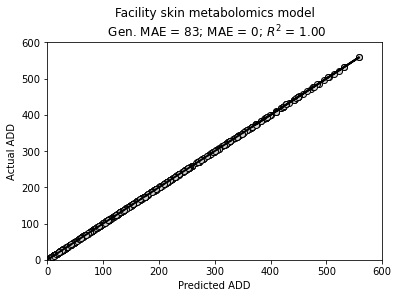

In [50]:
yhat = model_Metab_skin_meta.predict(X)
MAE = mean_absolute_error(y, yhat)

plt.scatter(yhat, y, color = 'lightgray', edgecolors = 'black')
lower = np.min(np.concatenate([y, yhat]))
upper = np.max(np.concatenate([y, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,y)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('Facility skin metabolomics model\n Gen. MAE = %d; MAE = %d; $R^2$ = %.2f' %(np.mean(nested_cv_scores),MAE,round(model_Metab_skin_meta.score(X,y),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/facility_skin_model.png')